In [14]:
# --- reader / flat-pack maker (robust) ---
import os, csv
import numpy as np

OUT_DIR = "lambda_dump"  # same folder you saved in

def load_Lambda(k_index, layer, sym, out_dir=OUT_DIR):
    fname = os.path.join(out_dir, f"k{k_index:05d}_L{layer}_S{sym}.npz")
    z = np.load(fname, allow_pickle=True)
    return {
        "k": z["k"],
        "layer": int(z["layer"]),
        "sym": int(z["sym"]),
        "Lambda": z["Lambda"],
        "evals_plus": z["evals_plus"],
        "evals_minus": z["evals_minus"],
    }

def _read_k_index_table(in_dir="lambda_dump"):
    path = os.path.join(in_dir, "k_index.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {path}")
    items = []
    with open(path, "r", newline="") as f:
        for row in csv.DictReader(f):
            items.append((int(row["k_index"]), float(row["kx"]), float(row["ky"])))
    return items  # list of (k_index, kx, ky)

def _quantize_pair(kx, ky, decimals=12):
    return (round(kx, decimals), round(ky, decimals))

def _build_partner_map(all_k, decimals=12):
    """
    Build dict: index_of_k  -> index_of_minus_k (if exists), else None
    """
    by_key = { _quantize_pair(kx, ky, decimals): idx for idx, kx, ky in all_k }
    partners = {}
    for idx, kx, ky in all_k:
        key_minus = _quantize_pair(-kx, -ky, decimals)
        partners[idx] = by_key.get(key_minus, None)
    return partners

def _two_flats(E):
    """Return indices of the two eigenvalues closest to zero."""
    E = np.asarray(E, float)
    o = np.argsort(np.abs(E))
    return np.sort(o[:2])

def _gather_L_blocks(k_index, layer, syms, in_dir):
    """Load Λ for given k_index, layer over syms. Returns list of Λ, and a z for eigenvalues."""
    Ls = []
    z_any = None
    for s in syms:
        z = load_Lambda(k_index, layer=layer, sym=s, out_dir=in_dir)
        Ls.append(z["Lambda"])
        if z_any is None:
            z_any = z
    return Ls, z_any

def make_flatpacks_from_store_triplet(
    *, in_dir="lambda_dump", out_dir="lambda_flat_triplet", k_indices=None, syms=(0,), decimals=12):
    #
    os.makedirs(out_dir, exist_ok=True)
    #
    all_k = _read_k_index_table(in_dir)
    
    if k_indices is not None:
        keep = set(int(i) for i in k_indices)
        all_k = [t for t in all_k if t[0] in keep]

    partner_of = _build_partner_map(all_k, decimals=decimals)
    syms = tuple(int(s) for s in syms)
    nS = len(syms)

    for k_index, kx, ky in all_k:
        pidx = partner_of[k_index]
        if pidx is None:
            # No exact partner found; skip;
            continue

        # load Λ^L_s and spectra (use s=syms[0] to grab eigenvalues/k)
        L0, z0 = _gather_L_blocks(k_index, layer=0, syms=syms, in_dir=in_dir)
        L1, z1 = _gather_L_blocks(k_index, layer=1, syms=syms, in_dir=in_dir)
        L0P, _  = _gather_L_blocks(pidx,    layer=0, syms=syms, in_dir=in_dir)
        L1P, _  = _gather_L_blocks(pidx,    layer=1, syms=syms, in_dir=in_dir)

        Eplus  = np.asarray(z0["evals_plus"],  float)
        Eminus = np.asarray(z0["evals_minus"], float)
        k_vec  = np.asarray(z0["k"], float)

        flat_plus  = _two_flats(Eplus)
        flat_minus = _two_flats(Eminus)

        L0flat = np.empty((nS, 2, 2), dtype=complex)
        L1flat = np.empty((nS, 2, 2), dtype=complex)
        
        for si, s in enumerate(syms):
            # triplet: antisym under k→-k (your pp convention uses transpose)
            L0flat[si] = (L0[si] - L0P[si].T)[np.ix_(flat_plus, flat_minus)] / 2.0
            L1flat[si] = (L1[si] - L1P[si].T)[np.ix_(flat_plus, flat_minus)] / 2.0

        out_path = os.path.join(out_dir, f"flat_k{k_index:05d}.npz")
        np.savez_compressed(
            out_path,L0flat=L0flat, L1flat=L1flat,
            Eplus_flat=Eplus[flat_plus],Eminus_flat=Eminus[flat_minus],
            flat_plus_idx=flat_plus,flat_minus_idx=flat_minus,
            k=k_vec, k_index=int(k_index),
            partner_index=int(pidx),syms=np.array(syms, int),
        )
    print(f"Flat packs written to {out_dir}/")

def make_flatpacks_from_store_singlet(
    *, in_dir="lambda_dump", out_dir="lambda_flat_singlet", k_indices=None, syms=(0,), decimals=12
):
    """
    Singlet (even) channel: (Λ(k) + Λ_partner(k)^T)/2 in your pp convention.
    """
    os.makedirs(out_dir, exist_ok=True)
    all_k = _read_k_index_table(in_dir)
    if k_indices is not None:
        keep = set(int(i) for i in k_indices)
        all_k = [t for t in all_k if t[0] in keep]

    partner_of = _build_partner_map(all_k, decimals=decimals)
    syms = tuple(int(s) for s in syms)
    nS = len(syms)

    for k_index, kx, ky in all_k:
        pidx = partner_of[k_index]
        if pidx is None:
            continue

        L0, z0 = _gather_L_blocks(k_index, layer=0, syms=syms, in_dir=in_dir)
        L1, z1 = _gather_L_blocks(k_index, layer=1, syms=syms, in_dir=in_dir)
        L0P, _  = _gather_L_blocks(pidx,    layer=0, syms=syms, in_dir=in_dir)
        L1P, _  = _gather_L_blocks(pidx,    layer=1, syms=syms, in_dir=in_dir)

        Eplus  = np.asarray(z0["evals_plus"],  float)
        Eminus = np.asarray(z0["evals_minus"], float)
        k_vec  = np.asarray(z0["k"], float)

        flat_plus  = _two_flats(Eplus)
        flat_minus = _two_flats(Eminus)

        L0flat = np.empty((nS, 2, 2), dtype=complex)
        L1flat = np.empty((nS, 2, 2), dtype=complex)
        for si, s in enumerate(syms):
            # singlet: symmetric under k→-k (transpose in your pp convention)
            L0flat[si] = (L0[si] + L0P[si].T)[np.ix_(flat_plus, flat_minus)] / 2.0
            L1flat[si] = (L1[si] + L1P[si].T)[np.ix_(flat_plus, flat_minus)] / 2.0

        out_path = os.path.join(out_dir, f"flat_k{k_index:05d}.npz")
        np.savez_compressed(
            out_path,
            L0flat=L0flat, L1flat=L1flat,
            Eplus_flat=Eplus[flat_plus],
            Eminus_flat=Eminus[flat_minus],
            flat_plus_idx=flat_plus,
            flat_minus_idx=flat_minus,
            k=k_vec, k_index=int(k_index),
            partner_index=int(pidx),
            syms=np.array(syms, int),
        )
    print(f"Flat packs written to {out_dir}/")

# One-time preprocessing (reads from lambda_dump/, writes to *_triplet / *_singlet)
make_flatpacks_from_store_triplet(in_dir="lambda_dump", out_dir="lambda_flat_triplet", syms=(0,))
make_flatpacks_from_store_singlet(in_dir="lambda_dump", out_dir="lambda_flat_singlet", syms=(0,))

Flat packs written to lambda_flat_triplet/
Flat packs written to lambda_flat_singlet/


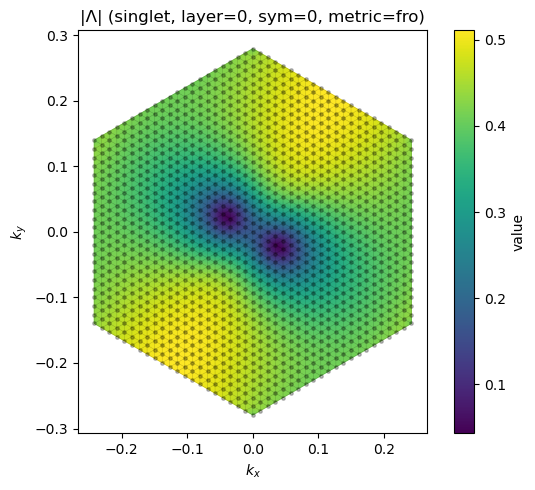

In [2]:
# visualize_lambda_mesh.py
import os, glob, csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

def _read_k_index_table(in_dir):
    path = os.path.join(in_dir, "k_index.csv")
    with open(path, "r", newline="") as f:
        return [(int(r["k_index"]), float(r["kx"]), float(r["ky"])) for r in csv.DictReader(f)]

def _metric_from_block(B, metric="fro"):
    """
    Compute a scalar from a 2x2 complex block.
    metric in {"fro","abs_trace","max_sv","max_abs"}
    """
    if metric == "fro":
        return float(np.linalg.norm(B, "fro"))
    elif metric == "abs_trace":
        return float(np.abs(np.trace(B)))
    elif metric == "max_sv":
        s = np.linalg.svd(B, compute_uv=False)
        return float(np.max(s))
    elif metric == "max_abs":
        return float(np.max(np.abs(B)))
    else:
        raise ValueError("Unknown metric")

def collect_flat_values(flat_dir, *, layer=0, sym_idx=0, metric="fro"):
    """
    Read all flat_kXXXXX.npz in flat_dir and compute a scalar per k.
    Returns: kx (N,), ky (N,), val (N,), kept_indices (list of int)
    """
    files = sorted(glob.glob(os.path.join(flat_dir, "flat_k*.npz")))
    kx_list, ky_list, val_list, idx_list = [], [], [], []

    for f in files:
        z = np.load(f, allow_pickle=True)
        k_index = int(z["k_index"])
        kvec = np.asarray(z["k"], float)  # shape (2,)
        # block array: (nS, 2, 2)
        if layer == 0:
            Lflat = np.asarray(z["L0flat"])
        elif layer == 1:
            Lflat = np.asarray(z["L1flat"])
        else:
            raise ValueError("layer must be 0 or 1")

        if sym_idx >= Lflat.shape[0]:
            # skip if that symmetry wasn't saved
            continue

        B = Lflat[sym_idx]  # (2,2)
        val = _metric_from_block(B, metric=metric)

        kx_list.append(kvec[0])
        ky_list.append(kvec[1])
        val_list.append(val)
        idx_list.append(k_index)

    kx = np.array(kx_list, float)
    ky = np.array(ky_list, float)
    vals = np.array(val_list, float)
    return kx, ky, vals, idx_list

def plot_scalar_on_mesh(
    kx, ky, vals, *, title, out_png=None,
    smooth=True,          # <- turn on Gouraud shading
    levels=24,            # used only when smooth=False
    show_edges=False,     # draw triangle edges
    vmin=None, vmax=None  # optional fixed color scale
):
    tri = mtri.Triangulation(kx, ky)
    plt.figure(figsize=(6, 5))

    if smooth:
        # Smoothly interpolate values inside triangles
        im = plt.tripcolor(tri, vals, shading="gouraud", vmin=vmin, vmax=vmax)
        if show_edges:
            plt.triplot(tri, lw=0.3, color="k", alpha=0.25)
    else:
        # Original filled contours
        im = plt.tricontourf(tri, vals, levels=levels, vmin=vmin, vmax=vmax)
        plt.tricontour(tri, vals, colors="k", linewidths=0.3, levels=levels)

    # Optional point markers (can comment out for dense meshes)
    plt.scatter(kx, ky, s=6, c="k", alpha=0.25)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.colorbar(im, label="value")
    plt.xlabel(r"$k_x$")
    plt.ylabel(r"$k_y$")
    plt.title(title)
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=200)
    plt.show()

def save_csv(kx, ky, vals, idx_list, out_csv):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["k_index","kx","ky","value"])
        for i, x, y, v in zip(idx_list, kx, ky, vals):
            w.writerow([i, x, y, v])

if __name__ == "__main__":
    # --- configure what to visualize ---
    # choose one of your precomputed folders:
    # flat_dir = "lambda_flat_triplet"
    # or:
    flat_dir = "lambda_flat_singlet"

    layer   = 0          # 0 or 1
    sym_idx = 0          # which entry inside syms (0 if syms=(0,))
    metric  = "fro"      # "fro", "abs_trace", "max_sv", or "max_abs"

    # --- load and plot ---
    kx, ky, vals, idx_list = collect_flat_values(flat_dir, layer=layer, sym_idx=sym_idx, metric=metric)

    # title & outputs
    ch = "triplet" if "triplet" in flat_dir else "singlet"
    title = f"|Λ| ({ch}, layer={layer}, sym={sym_idx}, metric={metric})"
    out_png = os.path.join(flat_dir, f"mesh_{ch}_L{layer}_S{sym_idx}_{metric}.png")
    plot_scalar_on_mesh(kx, ky, vals, title=title, smooth=True, show_edges=True,out_png=out_png)
    # optional: also save a CSV of the plotted data
    #out_csv = os.path.join(flat_dir, f"mesh_{ch}_L{layer}_S{sym_idx}_{metric}.csv")
    #save_csv(kx, ky, vals, idx_list, out_csv)
    
if __name__ == "__main__":
    # --- configure what to visualize ---
    # choose one of your precomputed folders:
    # flat_dir = "lambda_flat_triplet"
    # or:
    flat_dir = "lambda_flat_triplet"

    layer   = 0          # 0 or 1
    sym_idx = 0          # which entry inside syms (0 if syms=(0,))
    metric  = "fro"      # "fro", "abs_trace", "max_sv", or "max_abs"

    # --- load and plot ---
    kx, ky, vals, idx_list = collect_flat_values(flat_dir, layer=layer, sym_idx=sym_idx, metric=metric)

    # title & outputs
    ch = "triplet" if "triplet" in flat_dir else "singlet"
    title = f"|Λ| ({ch}, layer={layer}, sym={sym_idx}, metric={metric})"
    out_png = os.path.join(flat_dir, f"mesh_{ch}_L{layer}_S{sym_idx}_{metric}.png")
    plot_scalar_on_mesh(kx, ky, vals, title=title, smooth=True, show_edges=True,out_png=out_png)
    # optional: also save a CSV of the plotted data
    #out_csv = os.path.join(flat_dir, f"mesh_{ch}_L{layer}_S{sym_idx}_{metric}.csv")
    #save_csv(kx, ky, vals, idx_list, out_csv)

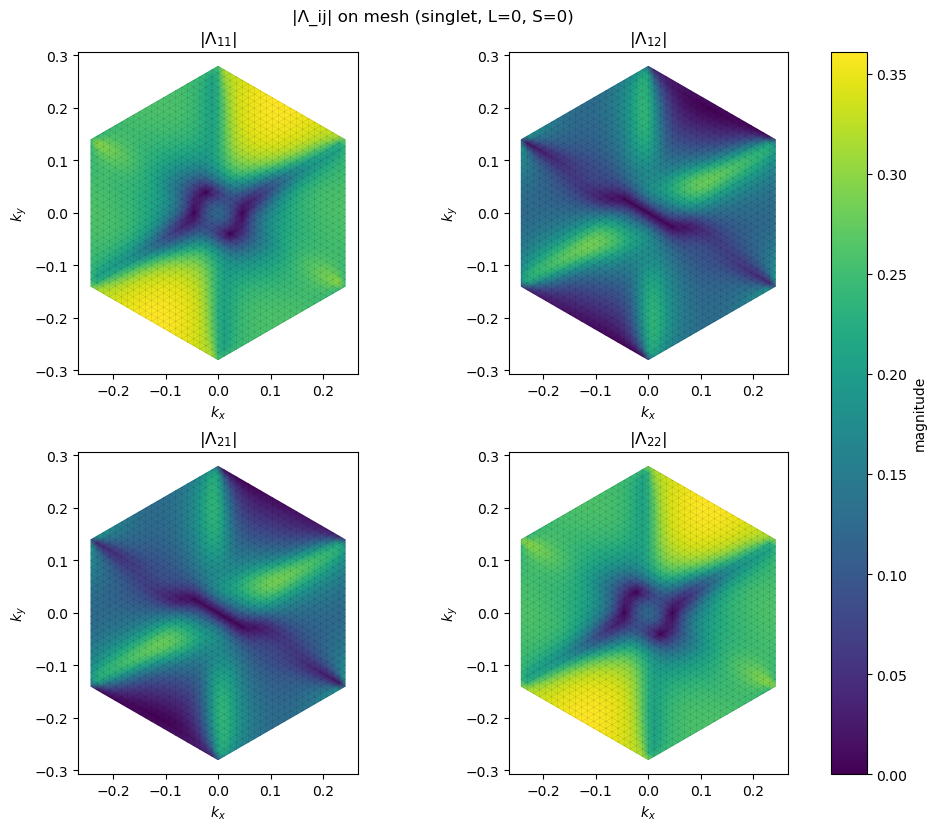

In [45]:
# --- add these helpers to your file ---

from matplotlib.colors import Normalize

def collect_element_abs_blocks(flat_dir, *, layer=0, sym_idx=0):
    """
    Read all flat_kXXXXX.npz and return |Λ_ij|(k) for each element.
    Returns: kx (N,), ky (N,), abs_blocks (N,2,2), kept_indices (list of int)
    """
    files = sorted(glob.glob(os.path.join(flat_dir, "flat_k*.npz")))
    kx_list, ky_list, blk_abs_list, idx_list = [], [], [], []

    for f in files:
        z = np.load(f, allow_pickle=True)
        k_index = int(z["k_index"])
        kvec = np.asarray(z["k"], float)
        Lflat = np.asarray(z["L0flat"] if layer == 0 else z["L1flat"])

        if sym_idx >= Lflat.shape[0]:
            continue  # this file doesn't have that symmetry index

        B = Lflat[sym_idx]               # (2,2)
        Babs = np.abs(B)                 # (2,2)

        kx_list.append(kvec[0])
        ky_list.append(kvec[1])
        blk_abs_list.append(Babs)
        idx_list.append(k_index)

    kx = np.array(kx_list, float)
    ky = np.array(ky_list, float)
    abs_blocks = np.array(blk_abs_list, float)   # shape (N,2,2)
    return kx, ky, abs_blocks, idx_list

def plot_element_abs_on_mesh(kx, ky, abs_blocks, *, title_prefix="", out_png=None,
                             smooth=True, show_edges=False, vmin=0.0, vmax=None):
    """
    Plot |Λ_ij|(k) for i,j in {1,2} as four subplots with shared colorbar.
    """
    tri = mtri.Triangulation(kx, ky)
    vals = [abs_blocks[:,0,0], abs_blocks[:,0,1], abs_blocks[:,1,0], abs_blocks[:,1,1]]
    labels = [r"$|\Lambda_{11}|$", r"$|\Lambda_{12}|$", r"$|\Lambda_{21}|$", r"$|\Lambda_{22}|$"]

    if vmax is None:
        vmax = float(np.nanmax(abs_blocks))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
    ims = []
    for ax, v, lab in zip(axes.ravel(), vals, labels):
        if smooth:
            im = ax.tripcolor(tri, v, shading="gouraud", vmin=vmin, vmax=vmax)
            if show_edges:
                ax.triplot(tri, lw=0.25, color="k", alpha=0.2)
        else:
            im = ax.tricontourf(tri, v, levels=24, vmin=vmin, vmax=vmax)
            ax.tricontour(tri, v, colors="k", linewidths=0.3, levels=24)

        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel(r"$k_x$")
        ax.set_ylabel(r"$k_y$")
        ax.set_title(lab)
        ims.append(im)

    # shared colorbar
    cbar = fig.colorbar(ims[0], ax=axes.ravel().tolist(), label="magnitude")
    if title_prefix:
        fig.suptitle(title_prefix, y=1.02)

    if out_png:
        fig.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()
    
if __name__ == "__main__":
    flat_dir = "lambda_flat_singlet"  # or "lambda_flat_triplet"
    layer   = 0
    sym_idx = 0
    ch = "triplet" if "triplet" in flat_dir else "singlet"

    # --- NEW: per-element |Λ_ij| plot ---
    kx, ky, abs_blocks, _ = collect_element_abs_blocks(flat_dir, layer=layer, sym_idx=sym_idx)
    title4 = f"|Λ_ij| on mesh ({ch}, L={layer}, S={sym_idx})"
    out_png4 = os.path.join(flat_dir, f"mesh_{ch}_L{layer}_S{sym_idx}_elemabs.png")
    plot_element_abs_on_mesh(kx, ky, abs_blocks, title_prefix=title4, show_edges=True, out_png=out_png4)

In [48]:
def avg_abs_element(abs_blocks, i=0, j=0):
    """
    Simple arithmetic average:
        (1/N) * sum_q |Λ_ij(q)|
    """
    if abs_blocks.size == 0:
        raise ValueError("abs_blocks is empty")
    vals = abs_blocks[:, i, j]  # already |Λ_ij|
    return float(np.mean(vals))

def avg_abs2_element(abs_blocks, i=0, j=0):
    """
    Simple arithmetic average of the squared magnitude:
        (1/N) * sum_q |Λ_ij(q)|^2
    """
    if abs_blocks.size == 0:
        raise ValueError("abs_blocks is empty")
    vals = abs_blocks[:, i, j]
    return float(np.mean(vals * vals))

mean_abs_11  = avg_abs_element(abs_blocks, i=0, j=0)
mean_abs2_11 = avg_abs2_element(abs_blocks, i=0, j=0)

print(f"(1/N) sum_q |Λ_11|     = {mean_abs_11:.8e}")
print(f"(1/N) sum_q |Λ_11|^2   = {mean_abs2_11:.8e}")
print(f"Ratio  = {mean_abs_11/mean_abs2_11:.8e}")


(1/N) sum_q |Λ_11|     = 2.38921748e-01
(1/N) sum_q |Λ_11|^2   = 6.25154248e-02
Ratio  = 3.82180476e+00


In [42]:
import numpy as np

def abs11_at_nearest(kx, ky, abs_blocks, kx_q, ky_q):
    """
    Nearest-neighbor lookup of |Λ_11| at query (kx_q, ky_q).
    Returns: value, index, distance
    """
    d = np.hypot(kx - kx_q, ky - ky_q)
    i = int(np.argmin(d))
    return float(abs_blocks[i, 0, 0]), i, float(d[i])

def abs11_at_linear(kx, ky, abs_blocks, kx_q, ky_q, _cache={}):
    # cache triangulation for speed
    key = id(kx)
    if key not in _cache:
        tri = mtri.Triangulation(kx, ky)
        vals = abs_blocks[:, 0, 0]
        _cache[key] = (tri, mtri.LinearTriInterpolator(tri, vals))
    tri, interp = _cache[key]
    v = interp(kx_q, ky_q)
    if np.ma.is_masked(v):
        return np.nan
    return float(v)


angle=np.pi/4; magnitudek=0.27;
val, idx, dist = abs11_at_nearest(kx, ky, abs_blocks, kx_q=magnitudek*np.cos(angle), ky_q=magnitudek*np.sin(angle))
print(f"|Λ_11|(nearest) = {val:.6g} at index={idx}, Δk = {dist:.3e}")

|Λ_11|(nearest) = 0.344065 at index=1381, Δk = 1.915e-02


In [44]:
# assumes you already have: kx, ky, abs_blocks, abs11_at_nearest(...)
tri = mtri.Triangulation(kx, ky)
interp = mtri.LinearTriInterpolator(tri, abs_blocks[:, 0, 0])  # for |Λ_11|

def ray_abs11(angle, kmax=0.30, npts=301):
    ks = np.linspace(0.0, kmax, npts)
    qx, qy = ks * np.cos(angle), ks * np.sin(angle)
    vals = np.empty_like(ks)
    for i, (qx_i, qy_i) in enumerate(zip(qx, qy)):
        v = interp(qx_i, qy_i)
        if np.ma.is_masked(v):  # outside convex hull → fallback
            v, _, _ = abs11_at_nearest(kx, ky, abs_blocks, qx_i, qy_i)
        else:
            v = float(v)
        vals[i] = v
    return ks, vals

plt.figure(figsize=(6, 4))
angles = [np.pi/3, np.pi/10, np.pi/2, np.pi]

for a in angles:
    ks, vals = ray_abs11(a, kmax=0.2, npts=301)
    plt.plot(ks, vals, linewidth=2, label=f"{a:.3f} rad")

plt.xlabel(r"$|\mathbf{k}|$")
plt.ylabel(r"$|\Lambda_{11}|$")
plt.title(r"$|\Lambda_{11}|$ vs $|\mathbf{k}|$ along multiple angles")
plt.grid(True, alpha=0.3)
plt.legend(title="angle")
plt.tight_layout()


In [30]:
# --- scan along a ray and plot ---
plt.figure(figsize=(6.0, 4.0))

angle = np.pi/3   # your requested direction
kmax  = 0.30
npts  = 301

ks = np.linspace(0.0, kmax, npts)
qx = ks * np.cos(angle)
qy = ks * np.sin(angle)

vals = np.empty_like(ks)
used_fallback = np.zeros_like(ks, dtype=bool)

for i, (qx_i, qy_i) in enumerate(zip(qx, qy)):
    v_lin = abs11_at_linear(kx, ky, abs_blocks, qx_i, qy_i)
    if np.isnan(v_lin):
        v_nn, _, _ = abs11_at_nearest(kx, ky, abs_blocks, qx_i, qy_i)
        vals[i] = v_nn
        used_fallback[i] = True
    else:
        vals[i] = v_lin

# --- plot |Λ_11| vs |k| ---
 
plt.plot(ks, vals, linewidth=2)

angle = np.pi/10   # your requested direction
kmax  = 0.30
npts  = 301

ks = np.linspace(0.0, kmax, npts)
qx = ks * np.cos(angle)
qy = ks * np.sin(angle)

vals = np.empty_like(ks)
used_fallback = np.zeros_like(ks, dtype=bool)

for i, (qx_i, qy_i) in enumerate(zip(qx, qy)):
    v_lin = abs11_at_linear(kx, ky, abs_blocks, qx_i, qy_i)
    if np.isnan(v_lin):
        v_nn, _, _ = abs11_at_nearest(kx, ky, abs_blocks, qx_i, qy_i)
        vals[i] = v_nn
        used_fallback[i] = True
    else:
        vals[i] = v_lin

# --- plot |Λ_11| vs |k| ---
 
    

plt.plot(ks, vals, linewidth=2)


angle = np.pi/2   # your requested direction
kmax  = 0.30
npts  = 301

ks = np.linspace(0.0, kmax, npts)
qx = ks * np.cos(angle)
qy = ks * np.sin(angle)

vals = np.empty_like(ks)
used_fallback = np.zeros_like(ks, dtype=bool)

for i, (qx_i, qy_i) in enumerate(zip(qx, qy)):
    v_lin = abs11_at_linear(kx, ky, abs_blocks, qx_i, qy_i)
    if np.isnan(v_lin):
        v_nn, _, _ = abs11_at_nearest(kx, ky, abs_blocks, qx_i, qy_i)
        vals[i] = v_nn
        used_fallback[i] = True
    else:
        vals[i] = v_lin
 
plt.plot(ks, vals, linewidth=2)

angle = np.pi   # your requested direction
kmax  = 0.30
npts  = 301

ks = np.linspace(0.0, kmax, npts)
qx = ks * np.cos(angle)
qy = ks * np.sin(angle)

vals = np.empty_like(ks)
used_fallback = np.zeros_like(ks, dtype=bool)

for i, (qx_i, qy_i) in enumerate(zip(qx, qy)):
    v_lin = abs11_at_linear(kx, ky, abs_blocks, qx_i, qy_i)
    if np.isnan(v_lin):
        v_nn, _, _ = abs11_at_nearest(kx, ky, abs_blocks, qx_i, qy_i)
        vals[i] = v_nn
        used_fallback[i] = True
    else:
        vals[i] = v_lin
 

plt.plot(ks, vals, linewidth=2)

plt.xlabel(r"$|\mathbf{k}|$")
plt.ylabel(r"$|\Lambda_{11}|$")
plt.title(rf"$|\Lambda_{{11}}|$ vs $|\mathbf{{k}}|$ along angle = {angle:.3f} rad")
plt.grid(True, alpha=0.3)
plt.tight_layout()



In [17]:
if __name__ == "__main__":
    flat_dir = "lambda_flat_triplet"  # or "lambda_flat_triplet"
    layer   = 0
    sym_idx = 0
    ch = "triplet" if "triplet" in flat_dir else "singlet"

    # --- NEW: per-element |Λ_ij| plot ---
    kx, ky, abs_blocks, _ = collect_element_abs_blocks(flat_dir, layer=layer, sym_idx=sym_idx)
    title4 = f"|Λ_ij| on mesh ({ch}, L={layer}, S={sym_idx})"
    out_png4 = os.path.join(flat_dir, f"mesh_{ch}_L{layer}_S{sym_idx}_elemabs.png")
    plot_element_abs_on_mesh(kx, ky, abs_blocks, title_prefix=title4, show_edges=True, out_png=out_png4)

In [45]:
# --- 1D scattering helpers (ring sampling) ---

import os, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

_EKEYS = {"11": (0,0), "12": (0,1), "21": (1,0), "22": (1,1)}

 
def _build_interps(kx, ky, blocks):
    """
    Build linear interpolators for Re and Im of each element.
    Returns: tri, { "11": (interp_re, interp_im), ... }
    """
    tri = mtri.Triangulation(kx, ky)
    interps = {}
    for key, (i,j) in _EKEYS.items():
        z = blocks[:, i, j]
        interps[key] = (
            mtri.LinearTriInterpolator(tri, np.real(z)),
            mtri.LinearTriInterpolator(tri, np.imag(z)),
        )
    return tri, interps

def _eval_complex(interp_pair, x, y):
    re = np.asarray(interp_pair[0](x, y))
    im = np.asarray(interp_pair[1](x, y))
    # fill masked values (outside convex hull) with nan
    if np.ma.isMaskedArray(re): re = re.filled(np.nan)
    if np.ma.isMaskedArray(im): im = im.filled(np.nan)
    return re + 1j*im

def plot_scattering_on_ring(
    kx, ky, blocks, *,
    center=(0.0, 0.0),
    radius=0.05,
    elems=("12", "21"),
    quantity="phase",           # "phase" or "magnitude"
    unwrap_phase=True,
    amp_min=1e-9,               # mask unreliable phase where |Λ| is tiny
    ntheta=512,
    annulus_halfwidth=0.0,      # >0 to average over a thin annulus
    n_radial_samples=5,
    title_prefix="",
    out_png=None
):
    """
    Sample Λ_ij on a ring |k-center|=radius and plot quantity vs polar angle θ.
    If annulus_halfwidth>0, average over radii in [r-Δ, r+Δ] to denoise.
    """
    _, interps = _build_interps(kx, ky, blocks)
    cx, cy = center
    theta = np.linspace(-np.pi, np.pi, ntheta, endpoint=False)

    # prepare radial samples
    if annulus_halfwidth > 0:
        r_list = np.linspace(radius - annulus_halfwidth, radius + annulus_halfwidth, n_radial_samples)
    else:
        r_list = [radius]

    fig, ax = plt.subplots(figsize=(9, 4.5))
    for key in elems:
        zr_all = []
        for r in r_list:
            x = cx + r * np.cos(theta)
            y = cy + r * np.sin(theta)
            z = _eval_complex(interps[key], x, y)
            zr_all.append(z)
        z_mean = np.nanmean(np.stack(zr_all, axis=0), axis=0)

        if quantity == "magnitude":
            yval = np.abs(z_mean)
            ax.set_ylabel(r"$|\Lambda_{ij}|$")
        else:  # phase
            yval = np.angle(z_mean)
            # mask near-zero amplitudes to avoid random phase
            yval = np.where(np.abs(z_mean) >= amp_min, yval, np.nan)
            if unwrap_phase:
                # unwrap while skipping NaNs by simple forward-fill approach
                mask = ~np.isnan(yval)
                ytmp = yval.copy()
                ytmp[mask] = np.unwrap(ytmp[mask])
                yval = ytmp
            ax.set_ylabel("phase (rad)")

        ax.plot(theta, yval, label=rf"$\Lambda_{{{key}}}$")

    ax.set_xlabel(r"angle $\theta$")
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                  labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"])
    ttl = f"{title_prefix}  (r={radius:.3g}"
    if annulus_halfwidth > 0:
        ttl += f"±{annulus_halfwidth:.3g}"
    ttl += ")"
    ax.set_title(ttl)
    ax.legend()
    ax.grid(alpha=0.25)

    if out_png:
        fig.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()
    
if __name__ == "__main__":
    flat_dir = "lambda_flat_singlet"  # or "lambda_flat_triplet"
    layer   = 0
    sym_idx = 0
    ch = "triplet" if "triplet" in flat_dir else "singlet"


    # --- NEW: 1D scattering plots along a ring around k=0 ---
    kx_c, ky_c, blocks_c, _ = collect_element_blocks(flat_dir, layer=layer, sym_idx=sym_idx)

    # Phase vs angle for off-diagonals (good for winding)
    plot_scattering_on_ring(
        kx_c, ky_c, blocks_c,
        center=(0.0, 0.0),
        radius=0.05,                 # choose a radius inside your zoom window
        elems=("12", "21","11", "22"),
        quantity="phase",
        unwrap_phase=True,
        amp_min=1e-6,
        annulus_halfwidth=0.005,     # small averaging band to denoise (optional)
        n_radial_samples=5,
        title_prefix=f"arg Λ_ij vs θ ({ch}, L={layer}, S={sym_idx})",
        out_png=os.path.join(flat_dir, f"scatt_phase_{ch}_L{layer}_S{sym_idx}.png"),
    )

    # Magnitude vs angle (optional)
    plot_scattering_on_ring(
        kx_c, ky_c, blocks_c,
        center=(0.0, 0.0),
        radius=0.05,
        elems=("11", "12", "21", "22"),
        quantity="magnitude",
        title_prefix=f"|Λ_ij| vs θ ({ch}, L={layer}, S={sym_idx})",
        out_png=os.path.join(flat_dir, f"scatt_mag_{ch}_L{layer}_S{sym_idx}.png"),
    )

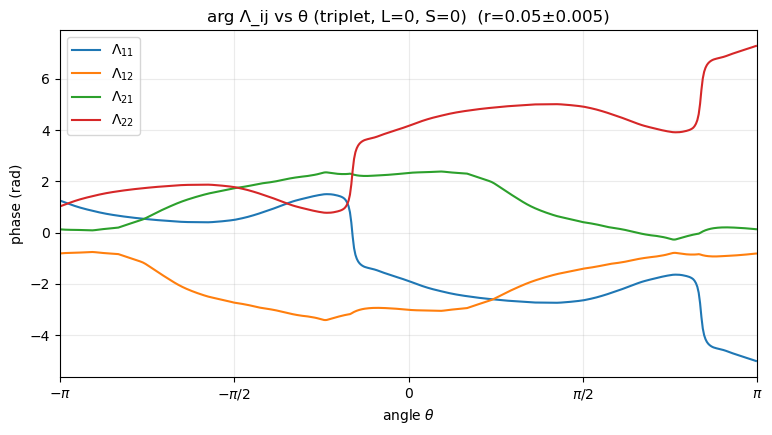

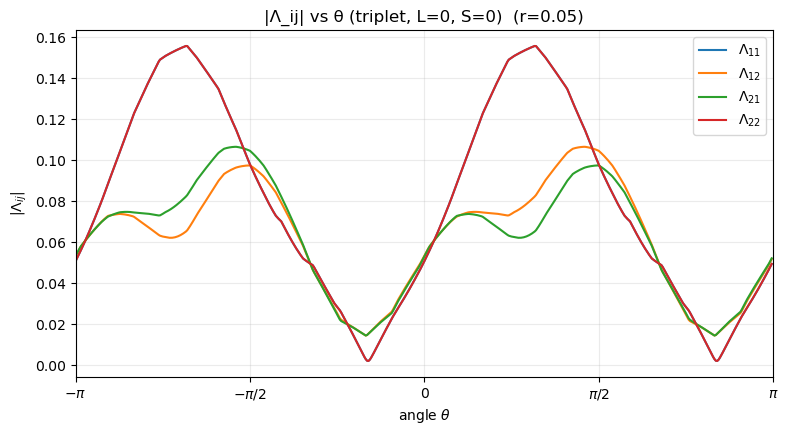

In [55]:
if __name__ == "__main__":
    flat_dir = "lambda_flat_triplet"  # or "lambda_flat_triplet"
    layer   = 0
    sym_idx = 0
    ch = "triplet" if "triplet" in flat_dir else "singlet"


    # --- NEW: 1D scattering plots along a ring around k=0 ---
    kx_c, ky_c, blocks_c, _ = collect_element_blocks(flat_dir, layer=layer, sym_idx=sym_idx)

    # Phase vs angle for off-diagonals (good for winding)
    plot_scattering_on_ring(
        kx_c, ky_c, blocks_c,
        center=(0.0, 0.0),
        radius=0.05,                 # choose a radius inside your zoom window
        elems=("11", "12", "21", "22"),
        quantity="phase",
        unwrap_phase=True,
        amp_min=1e-6,
        annulus_halfwidth=0.005,     # small averaging band to denoise (optional)
        n_radial_samples=5,
        title_prefix=f"arg Λ_ij vs θ ({ch}, L={layer}, S={sym_idx})",
        out_png=os.path.join(flat_dir, f"scatt_phase_{ch}_L{layer}_S{sym_idx}.png"),
    )

    # Magnitude vs angle (optional)
    plot_scattering_on_ring(
        kx_c, ky_c, blocks_c,
        center=(0.0, 0.0),
        radius=0.05,
        elems=("11", "12", "21", "22"),
        quantity="magnitude",
        title_prefix=f"|Λ_ij| vs θ ({ch}, L={layer}, S={sym_idx})",
        out_png=os.path.join(flat_dir, f"scatt_mag_{ch}_L{layer}_S{sym_idx}.png"),
    )

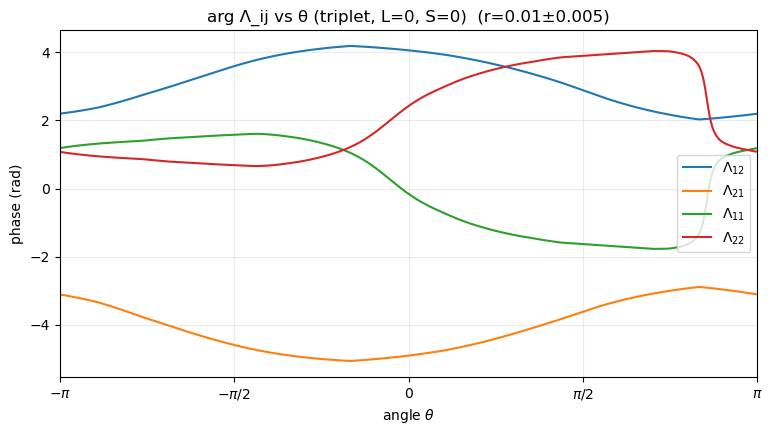

In [54]:
plot_scattering_on_ring(
        kx_c, ky_c, blocks_c,
        center=(0.05*np.cos(-np.pi/6), 0.05*np.sin(-np.pi/6)),
        radius=0.01,                 # choose a radius inside your zoom window
        elems=("12", "21","11", "22"),
        quantity="phase",
        unwrap_phase=True,
        amp_min=1e-6,
        annulus_halfwidth=0.005,     # small averaging band to denoise (optional)
        n_radial_samples=5,
        title_prefix=f"arg Λ_ij vs θ ({ch}, L={layer}, S={sym_idx})",
        out_png=os.path.join(flat_dir, f"scatt_phase_{ch}_L{layer}_S{sym_idx}.png"),
    )

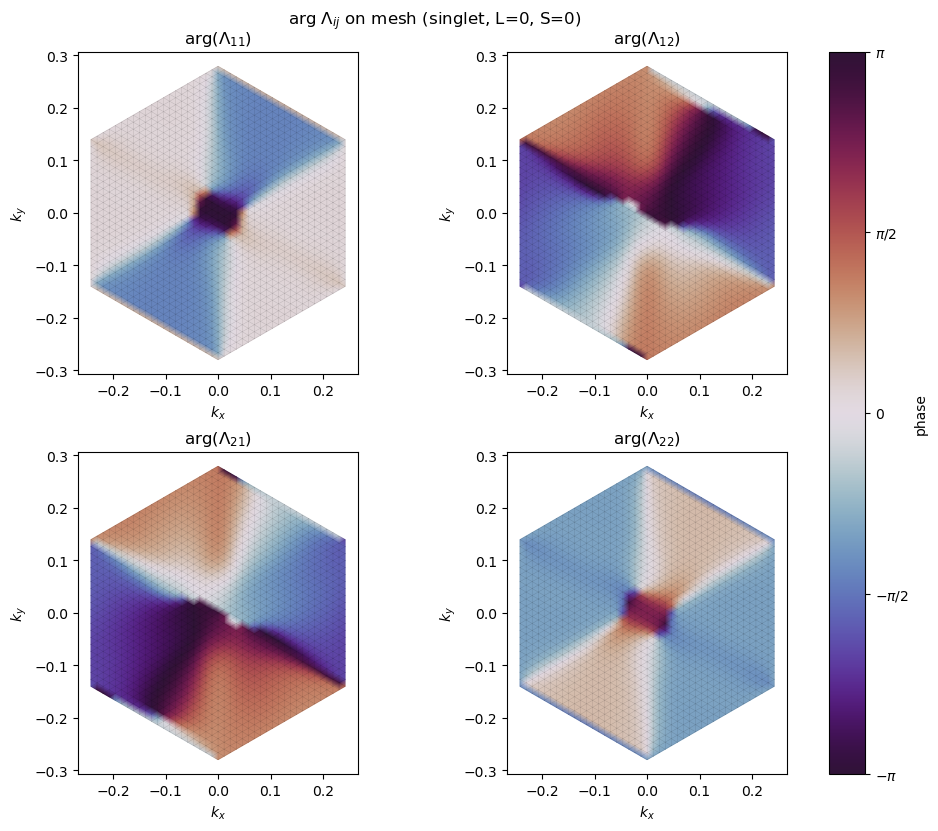

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.colors import Normalize


def plot_phase_elements_on_mesh(
    kx, ky, blocks, *,
    amp_min=0.0,            # mask tiny magnitudes (phase unreliable there)
    cmap="twilight_shifted",        # cyclic colormap ("twilight" or "hsv")
    show_edges=False,       # draw triangulation edges
    suptitle=None,          # overall title
    out_png=None            # path to save figure
):
    """
    kx, ky  : arrays of shape (N,)
    blocks  : array of shape (N, 2, 2), complex Λ blocks at each k
    """
    kx = np.asarray(kx, float)
    ky = np.asarray(ky, float)
    B  = np.asarray(blocks, complex)      # (N, 2, 2)

    # Extract elements as complex scalars over k
    Z = [B[:,0,0], B[:,0,1], B[:,1,0], B[:,1,1]]
    labels = [r"$\arg(\Lambda_{11})$", r"$\arg(\Lambda_{12})$",
              r"$\arg(\Lambda_{21})$", r"$\arg(\Lambda_{22})$"]

    # Compute masked phases in [-pi, pi]
    phases = []
    for z in Z:
        z = np.asarray(z)
        phase = np.angle(z)
        phase = np.where(np.abs(z) >= amp_min, phase, np.nan)
        phases.append(phase)

    tri = mtri.Triangulation(kx, ky)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

    # Common phase normalization and shared colorbar
    norm = Normalize(-np.pi, np.pi)
    ims = []
    for ax, ph, lab in zip(axes.ravel(), phases, labels):
        im = ax.tripcolor(tri, ph, shading="gouraud", cmap=cmap, norm=norm)
        if show_edges:
            ax.triplot(tri, lw=0.25, color="k", alpha=0.2)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel(r"$k_x$")
        ax.set_ylabel(r"$k_y$")
        ax.set_title(lab)
        ims.append(im)

    # One shared colorbar for all four panels
    cbar = fig.colorbar(ims[0], ax=axes.ravel().tolist(), ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels([r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"])
    cbar.set_label("phase")

    if suptitle:
        fig.suptitle(suptitle, y=1.02)

    if out_png:
        fig.savefig(out_png, dpi=220, bbox_inches="tight")

    plt.show()
    
import os, glob
import numpy as np

# Choose which set to plot
flat_dir = "lambda_flat_singlet"   # or "lambda_flat_triplet"
layer    = 0                       # 0 or 1
sym_idx  = 0                       # 0 if you saved syms=(0,)

# 1) Load all 2x2 blocks and k-points from the flat-packs
files = sorted(glob.glob(os.path.join(flat_dir, "flat_k*.npz")))  # sorted by k_index
kx, ky, blocks = [], [], []

for f in files:
    z = np.load(f, allow_pickle=True)
    arr = z["L0flat"] if layer == 0 else z["L1flat"]   # shape (nS, 2, 2)
    if sym_idx >= arr.shape[0]:
        continue  # this file doesn't have that symmetry index
    blocks.append(arr[sym_idx])                        # (2,2)
    k = np.asarray(z["k"], float)                      # (2,)
    kx.append(k[0]); ky.append(k[1])

kx = np.asarray(kx, float)
ky = np.asarray(ky, float)
blocks = np.asarray(blocks, complex)                   # shape (N, 2, 2)

 
    
# kx, ky: shape (N,)
# blocks: shape (N, 2, 2) from your flat-packs (e.g., L0flat or L1flat)
plot_phase_elements_on_mesh(
    kx, ky, blocks,
    amp_min=1e-6,
    cmap="twilight_shifted",
    show_edges=True,
    suptitle=r"arg $\Lambda_{ij}$ on mesh (singlet, L=0, S=0)",
    out_png="Singlet.png"
)

In [28]:
    
import os, glob
import numpy as np

# Choose which set to plot
flat_dir = "lambda_flat_triplet"   # or "lambda_flat_triplet"
layer    = 0                       # 0 or 1
sym_idx  = 0                       # 0 if you saved syms=(0,)

# 1) Load all 2x2 blocks and k-points from the flat-packs
files = sorted(glob.glob(os.path.join(flat_dir, "flat_k*.npz")))  # sorted by k_index
kx, ky, blocks = [], [], []

for f in files:
    z = np.load(f, allow_pickle=True)
    arr = z["L0flat"] if layer == 0 else z["L1flat"]   # shape (nS, 2, 2)
    if sym_idx >= arr.shape[0]:
        continue  # this file doesn't have that symmetry index
    blocks.append(arr[sym_idx])                        # (2,2)
    k = np.asarray(z["k"], float)                      # (2,)
    kx.append(k[0]); ky.append(k[1])

kx = np.asarray(kx, float)
ky = np.asarray(ky, float)
blocks = np.asarray(blocks, complex)                   # shape (N, 2, 2)

 
    
# kx, ky: shape (N,)
# blocks: shape (N, 2, 2) from your flat-packs (e.g., L0flat or L1flat)
plot_phase_elements_on_mesh(
    kx, ky, blocks,
    amp_min=1e-6,
    cmap="twilight_shifted",
    show_edges=True,
    suptitle=r"arg $\Lambda_{ij}$ on mesh (triplet, L=0, S=0)",
    out_png="Triplet.png"
)

In [ ]:
#### Confine to Origin

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.colors import Normalize

def plot_phase_elements_on_mesh(
    kx, ky, blocks, *,
    amp_min=0.0,                 # mask tiny magnitudes (phase unreliable there)
    cmap="twilight_shifted",     # cyclic colormap
    show_edges=False,            # draw triangulation edges
    suptitle=None,               # overall title
    out_png=None,                # path to save figure
    x_min=None,                  # keep None to allow x<0 in this zoom
    x_range=None,                # e.g. (-0.1, 0.1)
    y_range=None,                # e.g. (-0.1, 0.1)
    clip_to_window=True,         # mask triangles touching outside the window
    show_crosshair=True          # draw axes at kx=0, ky=0 to see winding center
):
    """
    kx, ky  : arrays of shape (N,)
    blocks  : array of shape (N, 2, 2), complex Λ blocks at each k
    """
    kx = np.asarray(kx, float)
    ky = np.asarray(ky, float)
    B  = np.asarray(blocks, complex)      # (N, 2, 2)

    # Extract elements as complex scalars over k
    Z = [B[:,0,0], B[:,0,1], B[:,1,0], B[:,1,1]]
    labels = [r"$\arg(\Lambda_{11})$", r"$\arg(\Lambda_{12})$",
              r"$\arg(\Lambda_{21})$", r"$\arg(\Lambda_{22})$"]

    # Compute masked phases in [-pi, pi]
    phases = []
    for z in Z:
        z = np.asarray(z)
        phase = np.angle(z)
        phase = np.where(np.abs(z) >= amp_min, phase, np.nan)
        phases.append(phase)

    # Triangulate once
    tri = mtri.Triangulation(kx, ky)

    # Collect window bounds if given
    have_window = (x_range is not None) and (y_range is not None)
    if have_window:
        xmin, xmax = sorted(x_range)
        ymin, ymax = sorted(y_range)

    # Build a mask for triangles outside constraints
    mask = None
    if x_min is not None:
        kx_tris = kx[tri.triangles]
        mask = np.any(kx_tris <= x_min, axis=1)

    if have_window and clip_to_window:
        kx_tris = kx[tri.triangles]
        ky_tris = ky[tri.triangles]
        outside = (kx_tris < xmin) | (kx_tris > xmax) | (ky_tris < ymin) | (ky_tris > ymax)
        mask = outside.any(axis=1) if mask is None else (mask | outside.any(axis=1))

    if mask is not None:
        tri.set_mask(mask)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

    # Common phase normalization and shared colorbar
    norm = Normalize(-np.pi, np.pi)
    ims = []
    for ax, ph, lab in zip(axes.ravel(), phases, labels):
        im = ax.tripcolor(tri, ph, shading="gouraud", cmap=cmap, norm=norm)
        if show_edges:
            ax.triplot(tri, lw=0.25, color="k", alpha=0.2)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel(r"$k_x$")
        ax.set_ylabel(r"$k_y$")
        ax.set_title(lab)

        # Apply the zoom box
        if have_window:
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)

        if show_crosshair:
            ax.axhline(0, lw=0.6, alpha=0.4)
            ax.axvline(0, lw=0.6, alpha=0.4)

        ims.append(im)

    # One shared colorbar for all four panels
    cbar = fig.colorbar(ims[0], ax=axes.ravel().tolist(),
                        ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels([r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"])
    cbar.set_label("phase")

    if suptitle:
        fig.suptitle(suptitle, y=1.02)

    if out_png:
        fig.savefig(out_png, dpi=220, bbox_inches="tight")

    plt.show()

    


In [38]:

# Choose which set to plot
flat_dir = "lambda_flat_triplet"   # or "lambda_flat_triplet"
layer    = 0                       # 0 or 1
sym_idx  = 0                       # 0 if you saved syms=(0,)

# 1) Load all 2x2 blocks and k-points from the flat-packs
files = sorted(glob.glob(os.path.join(flat_dir, "flat_k*.npz")))  # sorted by k_index
kx, ky, blocks = [], [], []

for f in files:
    z = np.load(f, allow_pickle=True)
    arr = z["L0flat"] if layer == 0 else z["L1flat"]   # shape (nS, 2, 2)
    if sym_idx >= arr.shape[0]:
        continue  # this file doesn't have that symmetry index
    blocks.append(arr[sym_idx])                        # (2,2)
    k = np.asarray(z["k"], float)                      # (2,)
    kx.append(k[0]); ky.append(k[1])

kx = np.asarray(kx, float)
ky = np.asarray(ky, float)
blocks = np.asarray(blocks, complex)       
    
plot_phase_elements_on_mesh(
    kx, ky, blocks,
    amp_min=1e-6,                 # consider lowering if the amplitude near 0 is tiny
    cmap="twilight_shifted",
    show_edges=True,
    suptitle=r"arg $\Lambda_{ij}$ on mesh (Triplet, L=0, S=0)",
    out_png="Triplet_zoom.png",
    x_min=None,                   # allow x<0 in this zoom
    x_range=(-0.1, 0.1),
    y_range=(-0.1, 0.1),
    clip_to_window=True,
    show_crosshair=True
)

In [56]:
import numpy as np

def winding_number_on_ring(kx, ky, z, center=(0.0,0.0), r_in=0.01, r_out=0.09, amp_min=1e-6):
    """
    Estimate phase winding of complex field z(k) around 'center'
    by summing phase differences along points in an annulus.
    """
    kx = np.asarray(kx); ky = np.asarray(ky); z = np.asarray(z)
    # select points in the annulus and with reliable amplitude
    dx, dy = kx-center[0], ky-center[1]
    r = np.hypot(dx, dy)
    sel = (r_in <= r) & (r <= r_out) & (np.abs(z) >= amp_min)
    if sel.sum() < 8:
        return np.nan  # too few points

    # order by polar angle around the center
    theta = np.arctan2(dy[sel], dx[sel])
    order = np.argsort(theta)
    zz = z[sel][order]

    # robust phase increments on the unit circle
    dphi = np.angle(zz[1:] * np.conj(zz[:-1]))
    # close the loop
    dphi = np.concatenate([dphi, [np.angle(zz[0] * np.conj(zz[-1]))]])
    w = np.sum(dphi) / (2*np.pi)
    return int(np.rint(w)), w  # (nearest integer, raw float)

# compute for off-diagonals
Z12 = blocks[:,0,1]
Z21 = blocks[:,1,0]
w12_i, w12 = winding_number_on_ring(kx, ky, Z12, r_in=0.01, r_out=0.09, amp_min=1e-6)
w21_i, w21 = winding_number_on_ring(kx, ky, Z21, r_in=0.01, r_out=0.09, amp_min=1e-6)
print("w(Λ12) ≈", w12, "→", w12_i)
print("w(Λ21) ≈", w21, "→", w21_i)

w(Λ12) ≈ -0.9999999999999997 → -1
w(Λ21) ≈ 1.0 → 1


In [75]:
import numpy as np

def winding_number_on_ring(kx, ky, z, *,
                           center=(0.0, 0.0),
                           r_in=0.01, r_out=0.09,
                           amp_min=1e-6,
                           verbose=False,
                           max_rows=None,          # None = print all steps
                           return_details=False):
    """
    Estimate winding number by summing wrapped phase differences around a ring.
    If verbose=True, print each incremental phase step and the running total.

    Returns:
        (w_int, w_float) if return_details is False
        else (w_int, w_float, details_dict)
    """
    kx = np.asarray(kx); ky = np.asarray(ky); z = np.asarray(z)

    # 1) pick an annulus and avoid tiny-|z| where phase is unreliable
    dx, dy = kx - center[0], ky - center[1]
    r = np.hypot(dx, dy)
    sel = (r_in <= r) & (r <= r_out) & (np.abs(z) >= amp_min)
    if sel.sum() < 8:
        if verbose:
            print(f"[winding] Too few points in annulus: {sel.sum()}")
        return (np.nan, np.nan) if not return_details else (np.nan, np.nan, {})

    # 2) order by polar angle
    theta = np.arctan2(dy[sel], dx[sel])
    order = np.argsort(theta)
    theta_sorted = theta[order]
    zz = z[sel][order]
    M = len(zz)

    # 3) compute wrapped increments including the closing step
    dphi = np.empty(M, float)
    for n in range(M):
        n2 = (n + 1) % M
        dphi[n] = np.angle(zz[n2] * np.conj(zz[n]))  # in (-pi, pi]

    w_float = np.sum(dphi) / (2*np.pi)
    w_int = int(np.rint(w_float))

    if verbose:
        header = (" idx |  θ_n(deg)  -> θ_{n+1}(deg) |   |z_n|      |z_{n+1}|   "
                  "|  Δφ(rad)  Δφ(deg) |  cumulative Δφ(rad)")
        print(header)
        print("-" * len(header))
        cum = 0.0
        rows_to_print = M if max_rows is None else min(M, max_rows)
        for n in range(rows_to_print):
            n2 = (n + 1) % M
            cum += dphi[n]
            print(f"{n:4d} | {np.degrees(theta_sorted[n]):9.2f} -> {np.degrees(theta_sorted[n2]):9.2f} | "
                  f"{abs(zz[n]):9.3e} {abs(zz[n2]):11.3e} | "
                  f"{dphi[n]:9.5f} {np.degrees(dphi[n]):8.2f} | {cum:18.5f}")
        if rows_to_print < M:
            print(f"... ({M - rows_to_print} more steps not shown)")
        print(f"\nTotal Δφ = {np.sum(dphi):.6f} rad  →  w = Δφ/(2π) = {w_float:+.6f}  →  round = {w_int:+d}")

    if return_details:
        return w_int, w_float, {
            "theta": theta_sorted,
            "z_on_ring": zz,
            "dphi": dphi,
        }
    return w_int, w_float

w_i, w, det = winding_number_on_ring(
    kx, ky, blocks[:,0,1],
    center=(0,0), r_in=0.02, r_out=0.09, amp_min=1e-6,
    verbose=True, max_rows=None, return_details=True
)

 idx |  θ_n(deg)  -> θ_{n+1}(deg) |   |z_n|      |z_{n+1}|   |  Δφ(rad)  Δφ(deg) |  cumulative Δφ(rad)
------------------------------------------------------------------------------------------------------
   0 |   -175.28 ->   -173.41 | 1.172e-01   7.832e-02 |   0.38638    22.14 |            0.38638
   1 |   -173.41 ->   -169.11 | 7.832e-02   5.150e-02 |   0.97916    56.10 |            1.36553
   2 |   -169.11 ->   -169.11 | 5.150e-02   1.084e-01 |  -1.14856   -65.81 |            0.21698
   3 |   -169.11 ->   -166.10 | 1.084e-01   1.339e-01 |  -0.11104    -6.36 |            0.10594
   4 |   -166.10 ->   -163.90 | 1.339e-01   6.894e-02 |   0.60891    34.89 |            0.71485
   5 |   -163.90 ->   -160.89 | 6.894e-02   9.695e-02 |  -0.30570   -17.52 |            0.40914
   6 |   -160.89 ->   -158.95 | 9.695e-02   1.222e-01 |  -0.16935    -9.70 |            0.23980
   7 |   -158.95 ->   -157.59 | 1.222e-01   1.433e-01 |  -0.12576    -7.21 |            0.11404
   8 |   -157.59 ->   -150

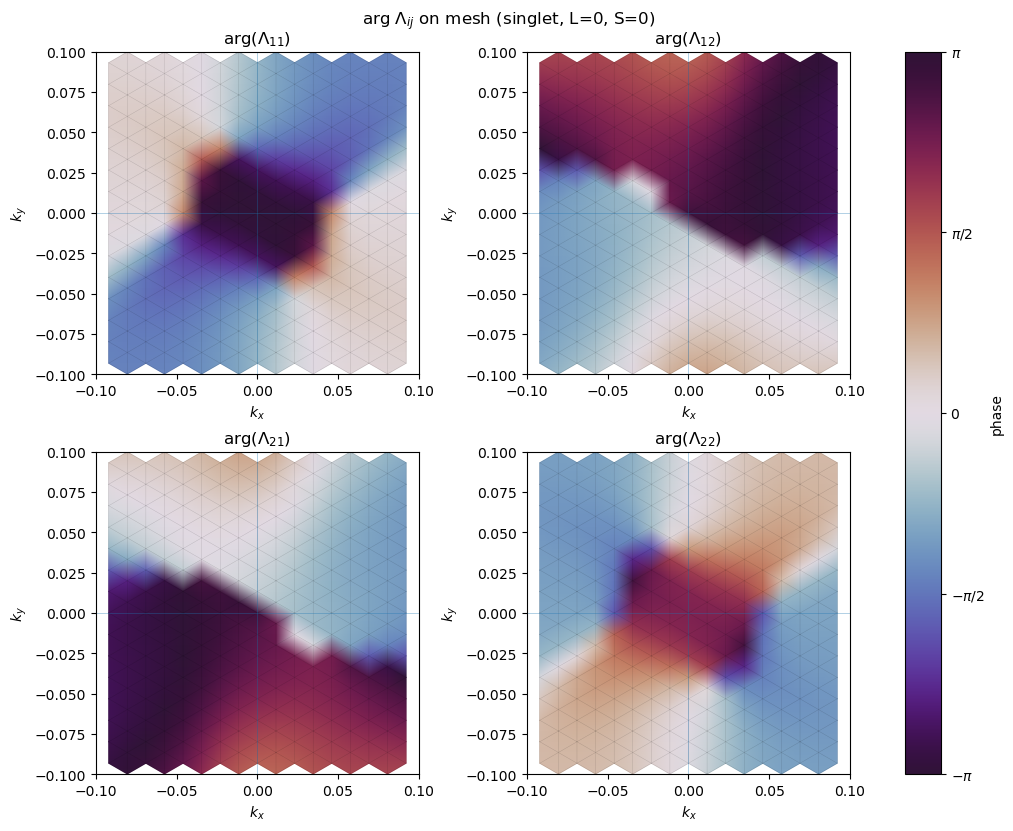

In [37]:

# Choose which set to plot
flat_dir = "lambda_flat_singlet"   # or "lambda_flat_triplet"
layer    = 0                       # 0 or 1
sym_idx  = 0                       # 0 if you saved syms=(0,)

# 1) Load all 2x2 blocks and k-points from the flat-packs
files = sorted(glob.glob(os.path.join(flat_dir, "flat_k*.npz")))  # sorted by k_index
kx, ky, blocks = [], [], []

for f in files:
    z = np.load(f, allow_pickle=True)
    arr = z["L0flat"] if layer == 0 else z["L1flat"]   # shape (nS, 2, 2)
    if sym_idx >= arr.shape[0]:
        continue  # this file doesn't have that symmetry index
    blocks.append(arr[sym_idx])                        # (2,2)
    k = np.asarray(z["k"], float)                      # (2,)
    kx.append(k[0]); ky.append(k[1])

kx = np.asarray(kx, float)
ky = np.asarray(ky, float)
blocks = np.asarray(blocks, complex)       
    
plot_phase_elements_on_mesh(
    kx, ky, blocks,
    amp_min=1e-6,                 # consider lowering if the amplitude near 0 is tiny
    cmap="twilight_shifted",
    show_edges=True,
    suptitle=r"arg $\Lambda_{ij}$ on mesh (singlet, L=0, S=0)",
    out_png="singlet_zoom.png",
    x_min=None,                   # allow x<0 in this zoom
    x_range=(-0.1, 0.1),
    y_range=(-0.1, 0.1),
    clip_to_window=True,
    show_crosshair=True
)